# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import time
from dateutil.parser import parse
import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Part1. Data Exploration

### 1.1 Explore and Clean Porfolio Data

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
#check portfolio data type
print (portfolio.dtypes)

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object


In [4]:
## check data size and missing value

print ("portfolio data shape : " + str(portfolio.shape))

print ("portfolio missing value : ")
print (portfolio.isnull().sum())

portfolio data shape : (10, 6)
portfolio missing value : 
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [5]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    #cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    #rename id as offer_id
    cleaned_portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
    
    return cleaned_portfolio

In [6]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head(10)

,channels,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,bogo,discount,informational
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,1,0,0
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,0,0,1
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,1,0,0
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,0,1,0
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,0,0,1
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,0,1,0


### 1.2 Explore and Clean Profile Data

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
#check profile data type
print (profile.dtypes)

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object


In [9]:
## check data size and missing value

print ("profile data shape : " + str(profile.shape))

print ("profile missing value : ")
print (profile.isnull().sum())

profile data shape : (17000, 5)
profile missing value : 
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [10]:
## gender and income has same size missing values, check there are the same rows

profile[profile['gender'].isna()]['income'].isna().sum()

#Rows missed gender also missed income'

2175

In [11]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    #rename id as person 
    profile.rename(columns={'id': 'person'}, inplace=True)
    
    return profile

In [12]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,became_member_on,gender,person,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,844
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,911
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,559
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,635
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,725


### 1.3 Explore and Clean Transcript Data

In [13]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [14]:
#check transcript data type
print (transcript.dtypes)

event     object
person    object
time       int64
value     object
dtype: object


In [15]:
## check data size and missing value
print ("transcript data shape : " + str(transcript.shape))

print ("transcript missing value : ")
print (transcript.isnull().sum())

transcript data shape : (306534, 4)
transcript missing value : 
event     0
person    0
time      0
value     0
dtype: int64


In [16]:
def clean_transcript_offer(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [17]:
offer = clean_transcript_offer(transcript)
offer.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [18]:
offer['event'].value_counts()

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

In [19]:
def clean_transcript_transaction(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    transaction = transcript[transcript['value'].apply(lambda x: True if ('amount' in x) or ('amount' in x) else False)]
    
    # extract the offer id from value column
    transaction['trans_amount'] = transaction['value'].apply(lambda x: x['amount'] if ('amount' in x) else x['amount'])
    
    return transaction

In [20]:
transaction = clean_transcript_transaction(transcript)
transaction.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,event,person,time,value,trans_amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97


Now we have 4 cleaned dataset:

* portfolio
* profile
* offer
* transaction

### 1.4 Customer Profile Overview

In [21]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
    memberdays.set_xlabel("Days")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = cleaned_profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

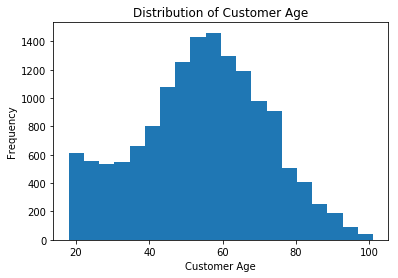

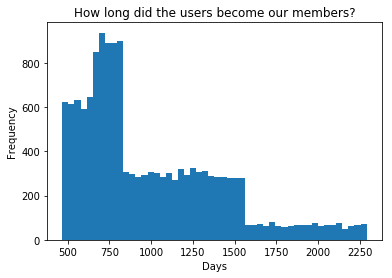

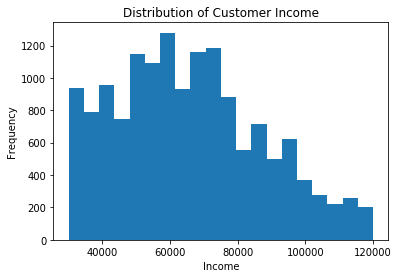

In [22]:
display_customer_profile()

### Customer Income and Age Exploration

In [23]:
# check statistics
cleaned_profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,990.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,468.000000
25%,42.000000,2.016052e+07,49000.000000,676.000000
50%,55.000000,2.017080e+07,64000.000000,826.000000
75%,66.000000,2.017123e+07,80000.000000,1265.000000
max,101.000000,2.018073e+07,120000.000000,2291.000000


In [24]:
## customer gender
(cleaned_profile.groupby(['gender'])['person'].count()/cleaned_profile.shape[0]).reset_index().iloc[:,:2]


,gender,person
0,F,0.413423
1,M,0.572277
2,O,0.014300


In [25]:
# mark age into different ranks 
income_rank = []

for i in cleaned_profile.income:
    if i <= 50000:       
        income_rank.append('30k~50k')
    elif i <= 65000:
        income_rank.append('50k~65k')
    elif i <= 80000:
        income_rank.append('65k~80k')
    elif i <= 95000:
        income_rank.append('80k~95k')  
    elif i<= 110000:
        income_rank.append('95k~110k')
    else:
        income_rank.append('110~130k')
    
cleaned_profile['income_rank'] = income_rank

In [26]:
# mark income into different ranks 
age_rank = []

for i in cleaned_profile.age:
    if i <= 30:       
        age_rank.append('18~30')
    elif i <= 45:
        age_rank.append('31~45')
    elif i <= 60:
        age_rank.append('46~60')
    elif i<= 75:
        age_rank.append('61~75')
    else:
        age_rank.append('75~101')
    
cleaned_profile['age_rank'] = age_rank

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


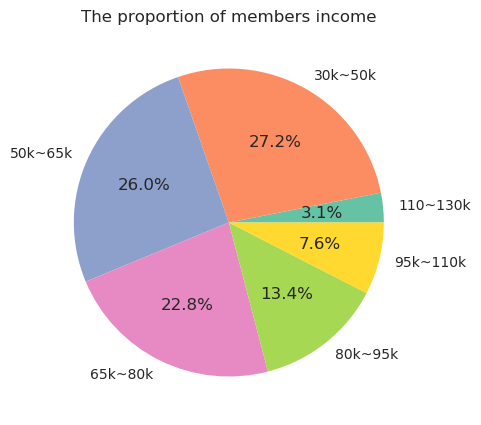

In [27]:
count_income = cleaned_profile.groupby(['income_rank']).count().reset_index()
count_income = count_income[['income_rank','person']]
count_income.columns = ['income_rank','counts']

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')

fig = plt.figure(figsize=(5,5))
ax = plt.title('The proportion of members income')
ax = fig.add_subplot(1, 1, 1)
ax.pie(count_income.counts, labels=count_income.income_rank, autopct="%1.1f%%")
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


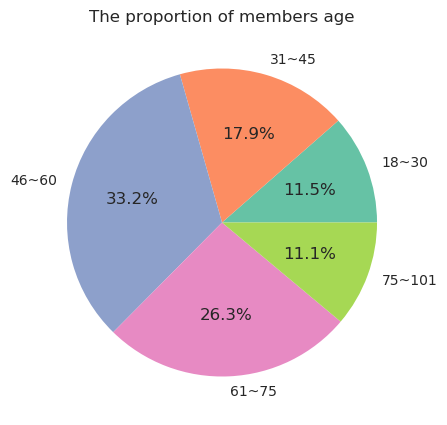

In [28]:
count_age = cleaned_profile.groupby(['age_rank']).count().reset_index()
count_age = count_age[['age_rank','person']]
count_age.columns = ['age_rank','counts']

plt.style.use('default')
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set2')

fig = plt.figure(figsize=(5,5))
ax = plt.title('The proportion of members age')
ax = fig.add_subplot(1, 1, 1)
ax.pie(count_age.counts, labels=count_age.age_rank, autopct="%1.1f%%")
plt.show()

### 1.5  Create Offer Completion Flag

In [29]:
# Create new dataframe of offer_id compeletion 
offer_portfolio = pd.merge(offer, cleaned_portfolio,how='inner',on='offer_id')

In [30]:
## offer_received 
offer_received = offer_portfolio[offer_portfolio['event']=='offer received']
offer_received.rename(columns={'time':'offer_start_time',
                              'event':'offer_received'}, inplace=True)
offer_received.drop(columns='value',axis=1, inplace=True)

## add required completion time
offer_received['required_completion'] = offer_received['offer_start_time'] + offer_received['duration']

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
offer_received.rename(columns={'time':'offer_start_time',
                              'event':'offer_received'}, inplace=True)

#offer completed

offer_completion = offer[offer['event']=='offer completed']
offer_completion.rename(columns={'event':'offer_completed',
                                'time':'offer_completed_time'}, inplace=True)
offer_completion.drop(columns='value', axis=1, inplace=True)

# offer viewed
offer_viewed = offer[offer['event']=='offer viewed']
offer_viewed.rename(columns={'event':'offer_viewed',
                                'time':'offer_viewed_time'}, inplace=True)
offer_viewed.drop(columns='value', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
print(offer_received.shape)
offer_cycle = pd.merge(offer_received, offer_viewed, on=['person','offer_id'], how='left')
print(offer_cycle.shape)
offer_cycle = pd.merge(offer_cycle, offer_completion, on=['person','offer_id'], how='left')
print(offer_cycle.shape)

(76277, 17)
(95321, 19)
(115609, 21)


In [33]:
def eligible_offer(df):
    '''
    since there are duplicated value in offer_cycle table, tag out true offer cycle.
    
    INPUT:
    offer_cycle - with dupliated value
    
    OUTPUT:
    offer_cycle - the cleaned offer cycle data frame
    
    '''
    start_time = df['offer_start_time']
    view_time = df['offer_viewed_time']
    completed_time = df['offer_completed_time']
    duration = df['duration']
    
    df['completed_duration'] = completed_time - start_time
    
    #eligible case 1:  viewed and completed offer
    filter1 = ((view_time.notna()) & (completed_time.notna())) 
    filter2 = (completed_time >= view_time) & (view_time >= start_time)
    #eligible case 2: viewed but didn't completed offer
    filter3 = ((view_time.notna()) & (completed_time.isna())) 
    filter4 = (view_time >= start_time)
    #eligible case 3: not view but completed offer 
    filter5 = ((view_time.isna()) & (completed_time.notna())) 
    filter6 = (completed_time >= start_time)
    #eligible case 4: not view and not completed offer 
    filter7= ((view_time.isna()) & (completed_time.isna())) 
    
    df = df[(filter1 & filter2)|(filter3 & filter4) | (filter5 & filter6) | (filter7)]
    
    # only keep one record for one start time of each offer
    df.sort_values(['person','offer_id','offer_start_time','offer_viewed_time','offer_completed_time'],\
                  ascending=[True,True,True,True,True],inplace=True)
    
    df.drop_duplicates(['person','offer_id', 'offer_start_time'], keep='first', inplace=True)

    return df

def offer_completed_flag(df):
    
    ##Assign offer completed type 
    
    #eligible case 1:  viewed and completed offer
    start_time = df['offer_start_time']
    view_time = df['offer_viewed_time']
    completed_time = df['offer_completed_time']
    duration = df['duration']
    filter1 = ((view_time.notna()) & (completed_time.notna())) 
    filter2 = (completed_time >= view_time) & (view_time >= start_time)
    #eligible case 2: viewed but didn't completed offer
    filter3 = ((view_time.notna()) & (completed_time.isna())) 
    filter4 = (view_time >= start_time)
    #eligible case 3: not view but completed offer 
    filter5 = ((view_time.isna()) & (completed_time.notna())) 
    filter6 = (completed_time >= start_time)
    completed_filter = (df['completed_duration'] <= df['duration'])
    completed_not_on_time_filter = (df['completed_duration'] > df['duration'])
    #eligible case 4: not view and not completed offer 
    filter7= ((view_time.isna()) & (completed_time.isna())) 
        
    ## viewed and completed in time flag
    df['viewed_completed_flag'] = np.where((filter1 & filter2 & completed_filter),
                                           1,
                                           0)
    ## didn't view and completed flag
    df['not_view_completed_flag'] = np.where((filter3 & filter4),
                                            1,
                                            0)
    
    # viewed but didn't complete flag
    df['viewed_not_completed_flag']= np.where(filter5 & filter6,
                                             1,
                                             0)
    # not view and not complete flag
    df['not_view_not_completed_flag']= np.where(filter7,
                                             1,
                                             0)
    
    return df
    
offer_cycle = eligible_offer(offer_cycle)  
offer_cycle = offer_completed_flag(offer_cycle)
offer_cycle.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(70158, 26)

In [34]:
print ("All Offers Record: ", offer_cycle.shape[0])
print ("viewed and completed in time Offers: ", offer_cycle['viewed_completed_flag'].sum(), \
       ",Percentage: ", offer_cycle['viewed_completed_flag'].sum() / offer_cycle.shape[0])
print ("didn't view and completed offers: ", offer_cycle['not_view_completed_flag'].sum(), \
      ",Percentage: ", offer_cycle['not_view_completed_flag'].sum() / offer_cycle.shape[0])
print ("viewed but didn't complete offers: ", offer_cycle['viewed_not_completed_flag'].sum(),\
       ",Percentage: ", offer_cycle['viewed_not_completed_flag'].sum() / offer_cycle.shape[0])
print ("Niether viewed nor completed offers: ", offer_cycle['not_view_not_completed_flag'].sum(),\
       ",Percentage: ", offer_cycle['not_view_not_completed_flag'].sum() / offer_cycle.shape[0])

All Offers Record:  70158
viewed and completed in time Offers:  23864 ,Percentage:  0.340146526412
didn't view and completed offers:  28859 ,Percentage:  0.411342968728
viewed but didn't complete offers:  5049 ,Percentage:  0.0719661335842
Niether viewed nor completed offers:  10780 ,Percentage:  0.153653182816


In [35]:
### merge offer with profile
offer_cycle = pd.merge(offer_cycle, cleaned_profile, how='left', on='person')
offer_cycle.shape

(70158, 33)

## Part2. Business Questions


* For each offer type: 
   * Which demographics are more likely to complete it?
   * Which demographics spent most?
   * Which channels are effective?

In [36]:
def vasl_gdf(cols,df):
    """
    input cols:list of columns
    output 
    """
    plt.figure(figsize=(12,8))
    gdf = pd.DataFrame(df.groupby(cols)['person'].count().rename('rate'))
    gdf = gdf / gdf.groupby(level=0).sum()
    gdf = gdf.reset_index()
    ax = plt.title('Offer completion vs. {}'.format(cols[1]))
    ax = sns.barplot(x=gdf[cols[0]],y=gdf.rate,hue=gdf[cols[1]],data=gdf);
    return gdf,ax

In [37]:
viewed_completed = offer_cycle[offer_cycle['viewed_completed_flag'] == 1]
not_view_completed = offer_cycle[offer_cycle['not_view_completed_flag'] == 1]
viewed_not_completed = offer_cycle[offer_cycle['viewed_not_completed_flag'] == 1]

### 2.1 Viewed and Completed Offers

(    viewed_completed_flag income_rank      rate
 0                       0    110~130k  0.028170
 1                       0     30k~50k  0.326774
 2                       0     50k~65k  0.260223
 3                       0     65k~80k  0.212294
 4                       0     80k~95k  0.108634
 5                       0    95k~110k  0.063905
 6                       1    110~130k  0.034956
 7                       1     30k~50k  0.197763
 8                       1     50k~65k  0.264965
 9                       1     65k~80k  0.249541
 10                      1     80k~95k  0.164642
 11                      1    95k~110k  0.088132,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab6d3fd0>)

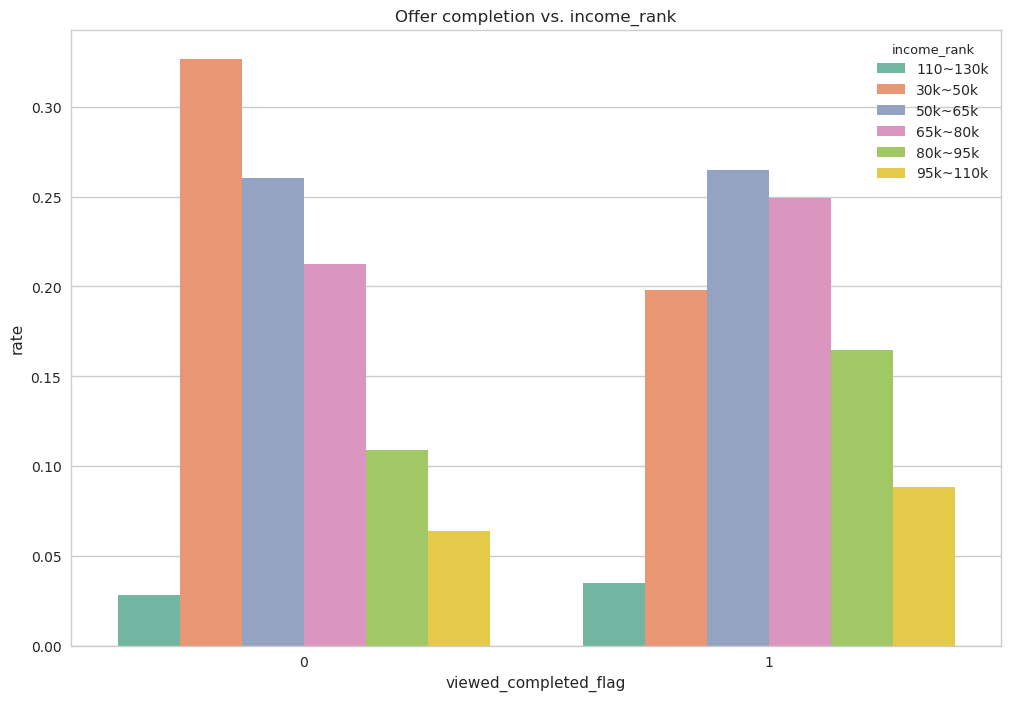

In [38]:
# Offer completion vs.income_rank totally
cols=['viewed_completed_flag','income_rank']
vasl_gdf(cols,offer_cycle)

(   offer_type income_rank      rate
 0        bogo    110~130k  0.041302
 1        bogo     30k~50k  0.180787
 2        bogo     50k~65k  0.261086
 3        bogo     65k~80k  0.249654
 4        bogo     80k~95k  0.172306
 5        bogo    95k~110k  0.094865
 6    discount    110~130k  0.029238
 7    discount     30k~50k  0.213058
 8    discount     50k~65k  0.268461
 9    discount     65k~80k  0.249439
 10   discount     80k~95k  0.157737
 11   discount    95k~110k  0.082067,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab6d0cc0>)

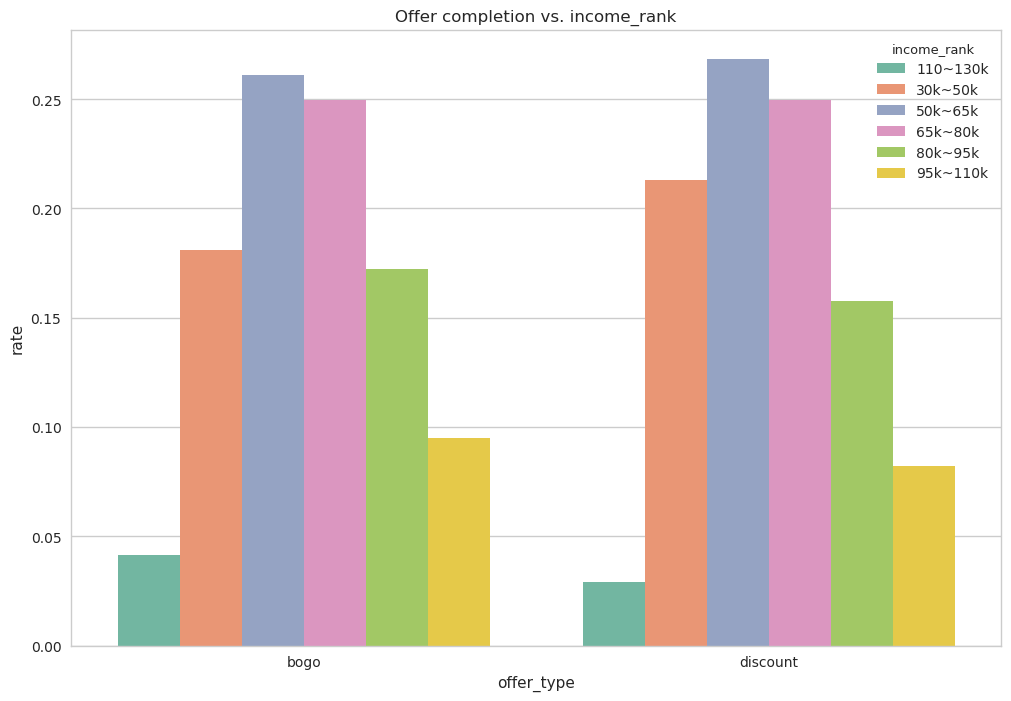

In [39]:
cols=['offer_type','income_rank']
vasl_gdf(cols,viewed_completed)

(   viewed_completed_flag age_rank      rate
 0                      0    18~30  0.134926
 1                      0    31~45  0.184256
 2                      0    46~60  0.322462
 3                      0    61~75  0.253002
 4                      0   75~101  0.105354
 5                      1    18~30  0.086996
 6                      1    31~45  0.175435
 7                      1    46~60  0.346762
 8                      1    61~75  0.273049
 9                      1   75~101  0.117758,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcd80ab748>)

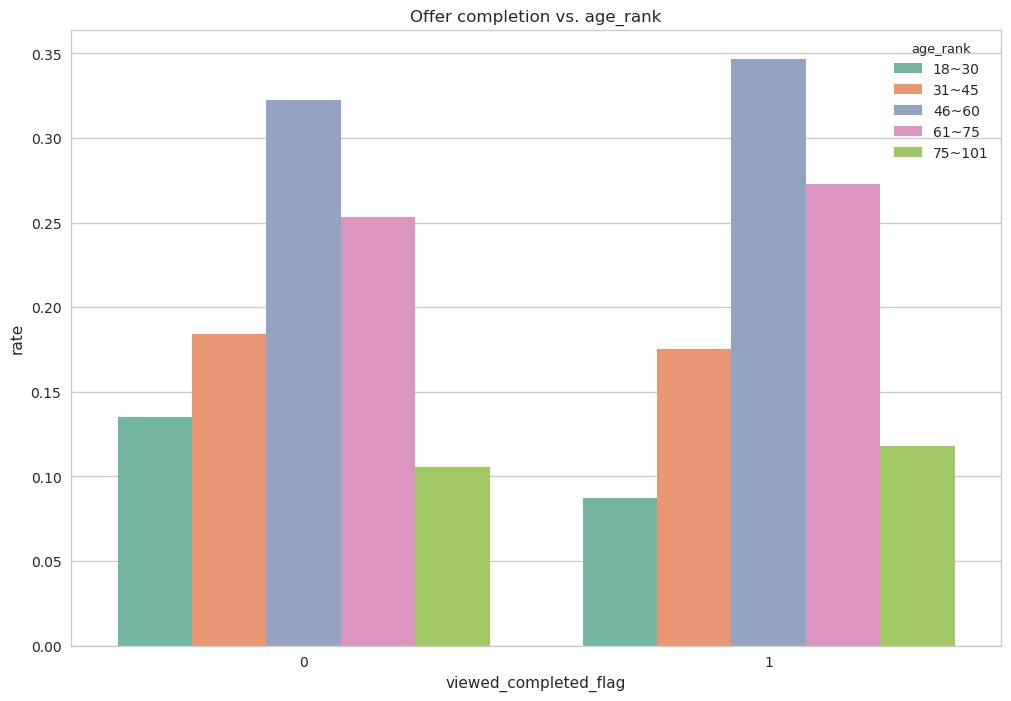

In [40]:
# Offer completion vs.age_rank 
cols=['viewed_completed_flag','age_rank']
vasl_gdf(cols,offer_cycle)

(  offer_type age_rank      rate
 0       bogo    18~30  0.080667
 1       bogo    31~45  0.172214
 2       bogo    46~60  0.350419
 3       bogo    61~75  0.273624
 4       bogo   75~101  0.123076
 5   discount    18~30  0.092699
 6   discount    31~45  0.178337
 7   discount    46~60  0.343467
 8   discount    61~75  0.272531
 9   discount   75~101  0.112966,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab7207b8>)

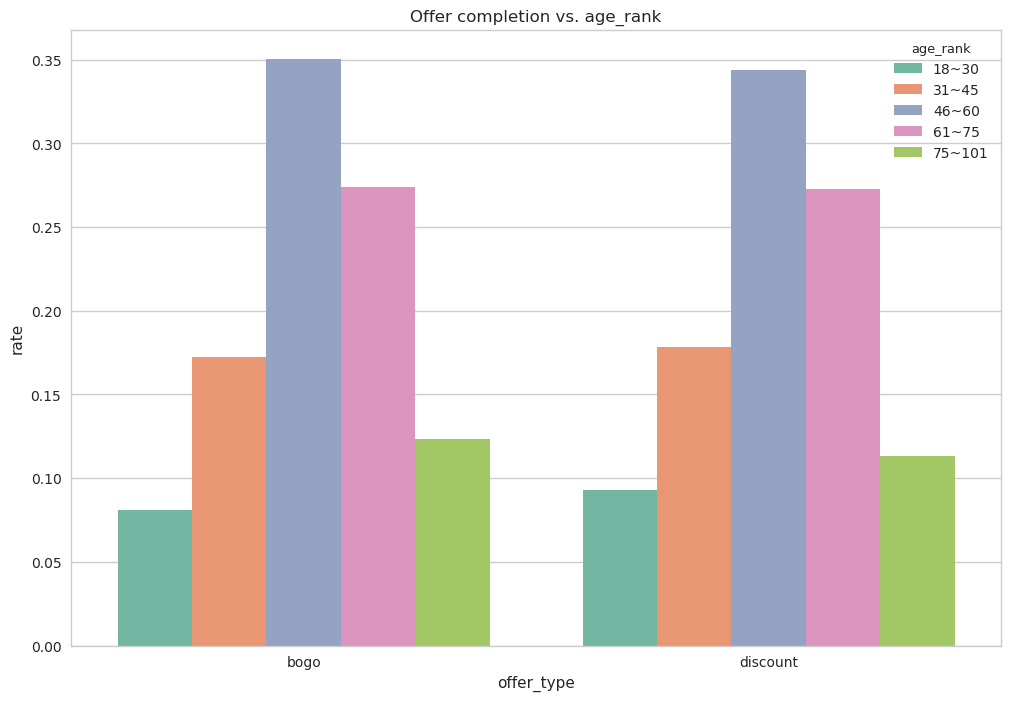

In [41]:
# Offer type s. age_rank
cols=['offer_type','age_rank']
vasl_gdf(cols,viewed_completed)
# didn't show strong prefence between two offers

(   viewed_completed_flag age_rank      rate
 0                      0    18~30  0.134926
 1                      0    31~45  0.184256
 2                      0    46~60  0.322462
 3                      0    61~75  0.253002
 4                      0   75~101  0.105354
 5                      1    18~30  0.086996
 6                      1    31~45  0.175435
 7                      1    46~60  0.346762
 8                      1    61~75  0.273049
 9                      1   75~101  0.117758,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab818048>)

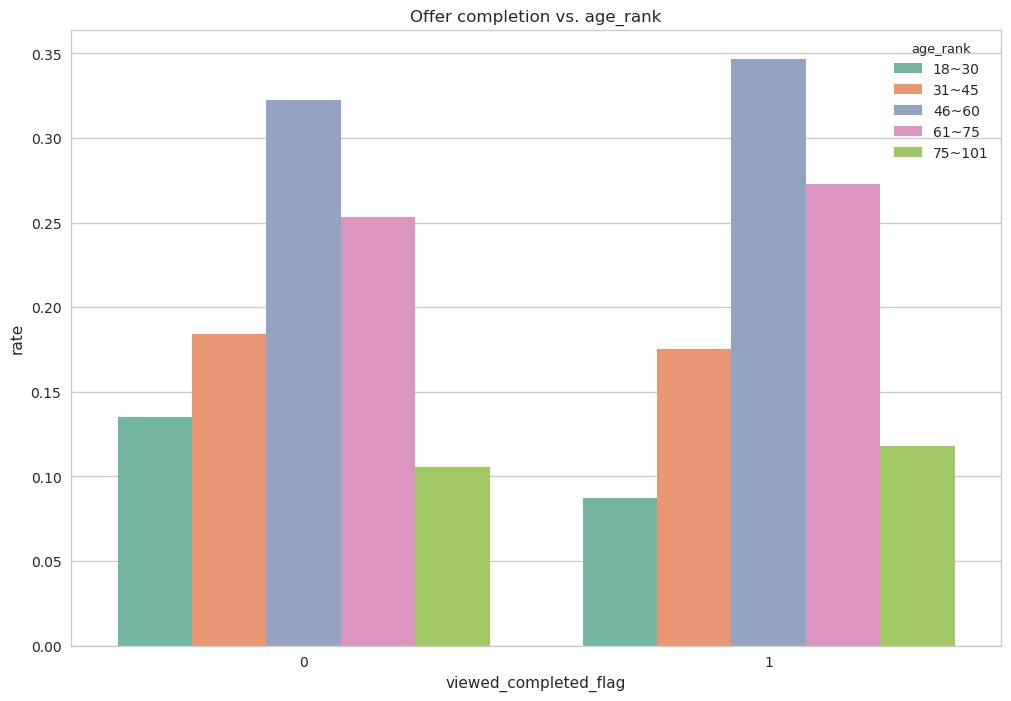

In [42]:
# Offer completion vs.age_rank totally
cols=['viewed_completed_flag','age_rank']
vasl_gdf(cols,offer_cycle)

### 2.2 Didn't View Offer but still Complete Offer
* this group have very strong consuming ability and intention

(    not_view_completed_flag income_rank      rate
 0                         0    110~130k  0.038049
 1                         0     30k~50k  0.255750
 2                         0     50k~65k  0.248783
 3                         0     65k~80k  0.233475
 4                         0     80k~95k  0.140360
 5                         0    95k~110k  0.083584
 6                         1    110~130k  0.017932
 7                         1     30k~50k  0.317243
 8                         1     50k~65k  0.285139
 9                         1     65k~80k  0.213865
 10                        1     80k~95k  0.111212
 11                        1    95k~110k  0.054610,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab5fb9e8>)

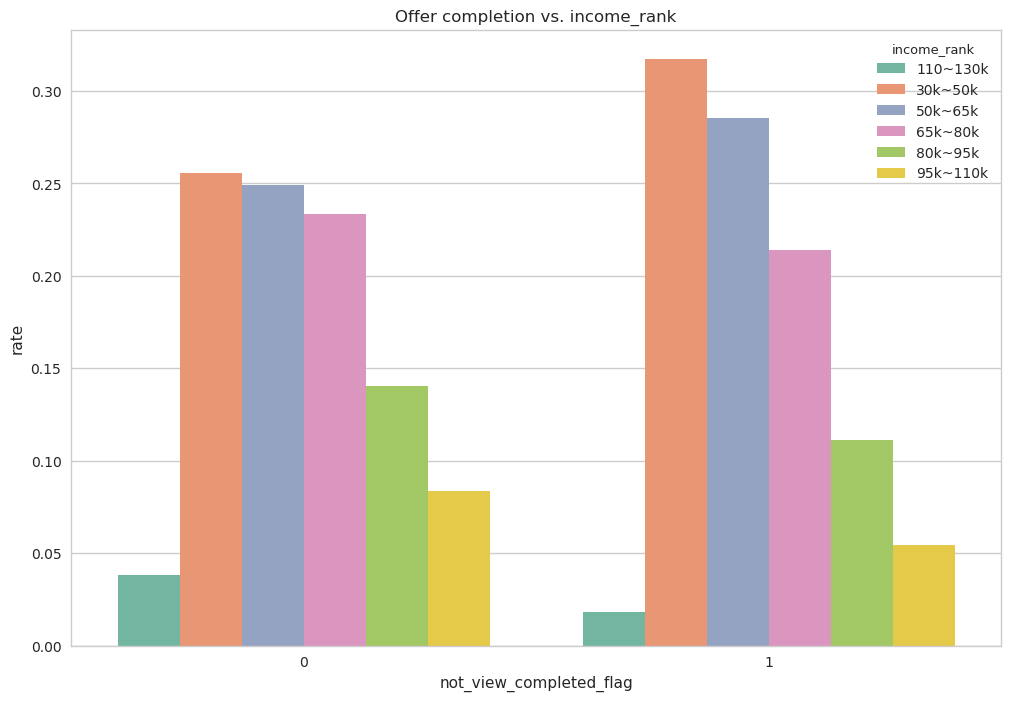

In [43]:
# Offer completion vs.income_rank totally
cols=['not_view_completed_flag','income_rank']
vasl_gdf(cols,offer_cycle)

(   not_view_completed_flag age_rank      rate
 0                        0    18~30  0.108967
 1                        0    31~45  0.174109
 2                        0    46~60  0.335967
 3                        0    61~75  0.266888
 4                        0   75~101  0.114070
 5                        1    18~30  0.130638
 6                        1    31~45  0.192855
 7                        1    46~60  0.324036
 8                        1    61~75  0.249502
 9                        1   75~101  0.102970,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab63fd68>)

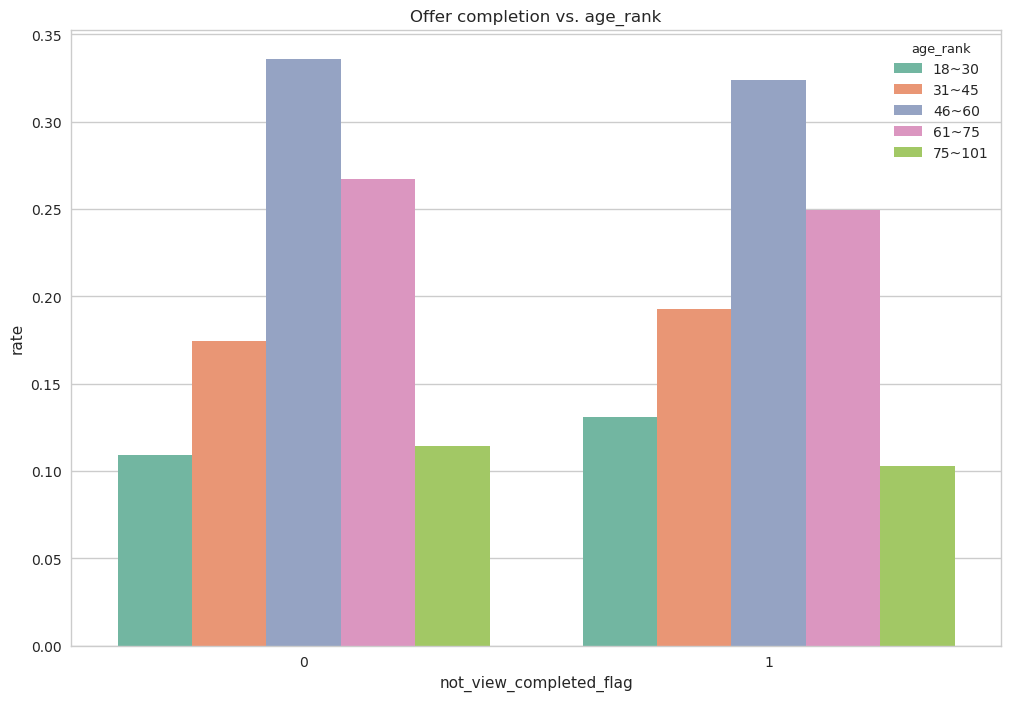

In [44]:
# Offer completion vs.age_rank totally
cols=['not_view_completed_flag','age_rank']
vasl_gdf(cols,offer_cycle)

### 2.3 Viewed but still not Completed Offer

(    viewed_not_completed_flag income_rank      rate
 0                           0    110~130k  0.028037
 1                           0     30k~50k  0.281289
 2                           0     50k~65k  0.269001
 3                           0     65k~80k  0.225304
 4                           0     80k~95k  0.127612
 5                           0    95k~110k  0.068757
 6                           1    110~130k  0.061072
 7                           1     30k~50k  0.242467
 8                           1     50k~65k  0.183215
 9                           1     65k~80k  0.238018
 10                          1     80k~95k  0.153893
 11                          1    95k~110k  0.121335,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab6c2e10>)

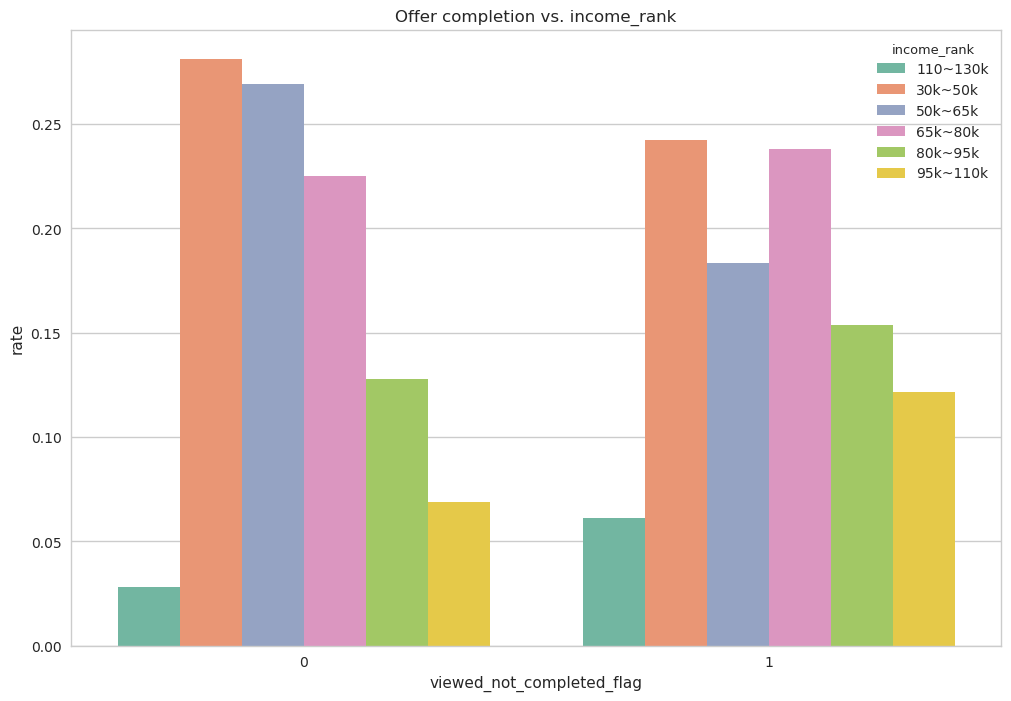

In [45]:
# Offer completion vs.income_rank totally
cols=['viewed_not_completed_flag','income_rank']
vasl_gdf(cols,offer_cycle)

(   viewed_not_completed_flag age_rank      rate
 0                          0    18~30  0.117710
 1                          0    31~45  0.184799
 2                          0    46~60  0.330439
 3                          0    61~75  0.258435
 4                          0   75~101  0.108616
 5                          1    18~30  0.107179
 6                          1    31~45  0.137310
 7                          1    46~60  0.344995
 8                          1    61~75  0.284530
 9                          1   75~101  0.125986,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcab68de10>)

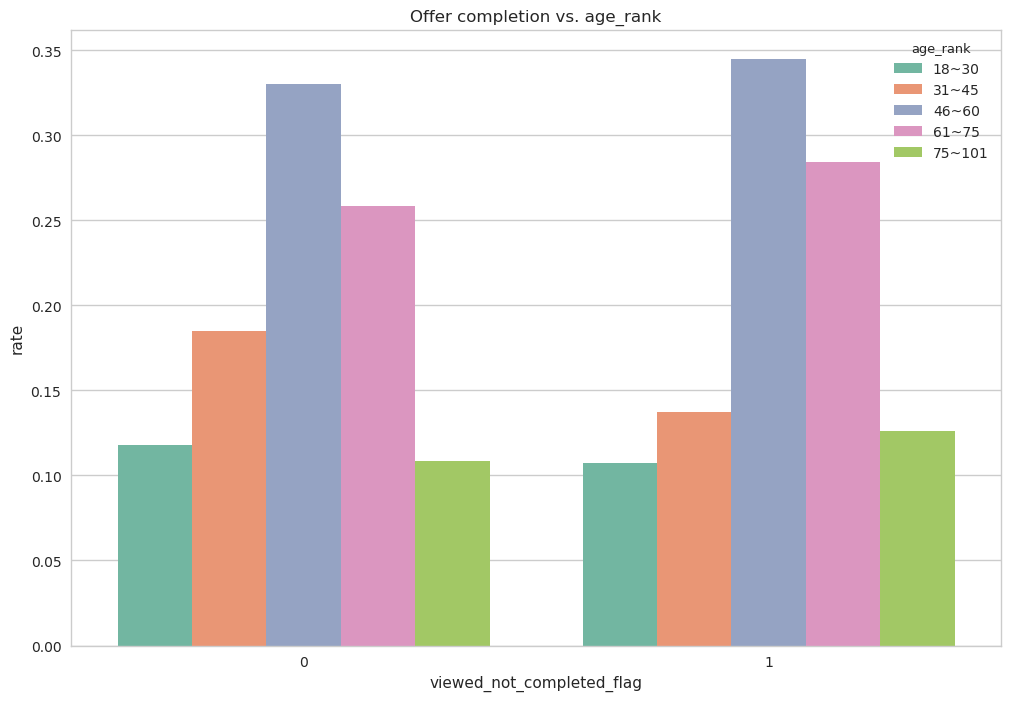

In [46]:
# Offer completion vs.income_rank totally
cols=['viewed_not_completed_flag','age_rank']
vasl_gdf(cols,offer_cycle)

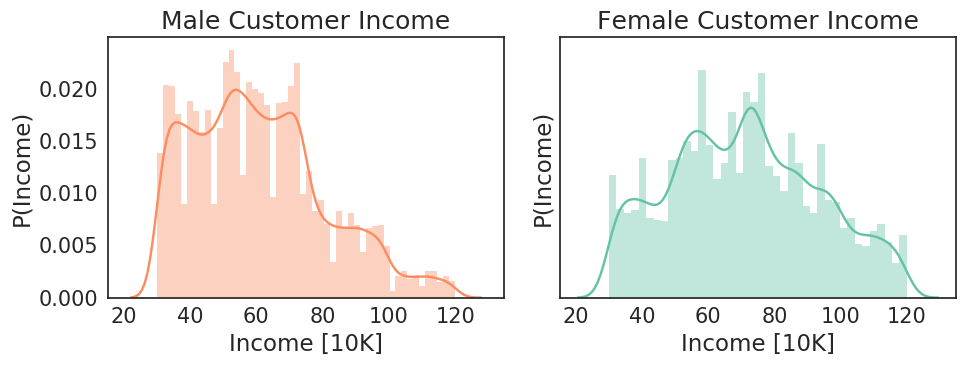

In [47]:
## Income by gender
male_customers = offer_cycle[offer_cycle['gender'] == "M"]
female_customers = offer_cycle[offer_cycle['gender'] == "F"]

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3,
             color=current_palette[1])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3,
             color=current_palette[0])
plt.xlabel('Income [10K]')
plt.ylabel('P(Income)')
plt.title('Female Customer Income')
plt.tight_layout()

## Part 3. Modeling - Predict who will complete offer

#### will apply and compare 3 models: Logistic Regression, Random Forest and AdaboostClassifier 

In [48]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2
import os

In [49]:
offer_cycle.columns

Index(['offer_received', 'person', 'offer_start_time', 'offer_id', 'channels',
       'difficulty', 'duration', 'offer_type', 'reward', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational',
       'required_completion', 'offer_viewed', 'offer_viewed_time',
       'offer_completed', 'offer_completed_time', 'completed_duration',
       'viewed_completed_flag', 'not_view_completed_flag',
       'viewed_not_completed_flag', 'not_view_not_completed_flag', 'age',
       'became_member_on', 'gender', 'income', 'memberdays', 'income_rank',
       'age_rank'],
      dtype='object')

In [50]:
def features(df):
    # apply one hot encoding to offer_type column
    df['became_member_year'] = df['became_member_on'].apply(lambda x: str(x)[:4])
    df['viewed_flag'] = np.where(df['offer_viewed_time'].notna(),
                                1,
                                0)
    member_band = pd.get_dummies(df['became_member_year'])
    age_band = pd.get_dummies(df['age_rank'])
    income_band = pd.get_dummies(df['income_rank'])
    gender = pd.get_dummies(df['gender'])

    # drop the channels and offer_type column

    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    df2 = pd.concat([df, age_band], axis=1, sort=False)
    df2 = pd.concat([df2, income_band], axis=1, sort=False)
    df2 = pd.concat([df2, gender], axis=1, sort=False)
    df2 = pd.concat([df2, member_band], axis=1, sort=False)
    
    
    return df2

In [51]:
offer_df = features(offer_cycle)
offer_df

,offer_received,person,offer_start_time,offer_id,channels,difficulty,duration,offer_type,reward,web,...,F,M,O,2013,2014,2015,2016,2017,2018,nan
0,offer received,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,168,discount,2,1,...,0,1,0,0,0,0,0,1,0,0
1,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,96,informational,0,1,...,0,1,0,0,0,0,0,1,0,0
2,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,72,informational,0,0,...,0,1,0,0,0,0,0,1,0,0
3,offer received,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,120,bogo,5,1,...,0,0,0,0,0,0,0,0,0,1
4,offer received,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,120,bogo,5,1,...,0,0,0,0,0,0,0,0,0,1
5,offer received,0011e0d4e6b944f998e987f904e8c1e5,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20,240,discount,5,1,...,0,0,1,0,0,0,0,0,1,0
6,offer received,0011e0d4e6b944f998e987f904e8c1e5,168,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,168,discount,3,1,...,0,0,1,0,0,0,0,0,1,0
7,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,96,informational,0,1,...,0,0,1,0,0,0,0,0,1,0
8,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,72,informational,0,0,...,0,0,1,0,0,0,0,0,1,0
9,offer received,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5,168,bogo,5,1,...,0,0,1,0,0,0,0,0,1,0


In [52]:
clean_data = offer_df[['viewed_completed_flag','viewed_flag','difficulty', 'duration','reward', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational','age','income',
       'required_completion','memberdays', '18~30', '31~45', '46~60', '61~75', '75~101',
       '110~130k', '30k~50k',
       '50k~65k', '65k~80k', '80k~95k', '95k~110k', 'F', 'M', 'O',
       '2013', '2014', '2015', '2016', '2017', '2018']]
clean_data.fillna(0,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [53]:
scaler = MinMaxScaler()

scaled_df = scaler.fit_transform(clean_data)
clean_data = pd.DataFrame(scaled_df, columns=list(clean_data.columns))

In [54]:

dfa = clean_data[:25000]
dfb = clean_data[25001:45000]
dfc = clean_data[45001:]

modf = [dfa, dfb, dfc]

Here we use selectkbest to do feature selection, so that to know about the influence for completion. And 3 clusters to train data, they are SVC, RandomforestClassifier, AdaboostClassifier.

In [55]:
selector = SelectKBest(k=5)

def make_pipeline(selector, clf, param_grid, x, y):
    pipe = Pipeline([
        ('fea_sel',selector),
        ('clf',clf)
    ])
    
    start = time.time()
    
    grid = GridSearchCV(pipe,cv=3,param_grid=param_grid)
    grid.fit(x, y)
    y_preds = grid.predict(x)
    f1score = f1_score(y_preds, y)
    accura = accuracy_score(y_preds, y)
    
    end = time.time()
    cost = end - start
    
    return pipe, grid, y_preds, f1score, accura, cost

In [56]:
acc = []
f1 = []
total_time = 0
lgdict = {}
for df in modf:
    x = df.drop(['viewed_completed_flag'],axis=1)
    y = df['viewed_completed_flag']
    clf = LogisticRegression(random_state=18,solver='lbfgs',
                             multi_class='multinomial')
    param_grid = {'clf__C':[0.1, 1, 10,100]}
    
    pipe, grid, y_preds, f1score, accura, cost = make_pipeline(selector, clf, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)

lgdict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.80436 0.737818279282
2.0348658561706543


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.7999899995 0.721487258042
1.6362082958221436


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.813451524427 0.736511144798
1.9661216735839844
5.637195825576782


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [57]:
lgdict

{'accuracy': 0.80593384130885859,
 'f1_score': 0.73193889404063583,
 'total_time': 5.637195825576782}

In [58]:
acc = []
f1 = []
total_time = 0
rfcdict = {}
for df in modf:
    x = df.drop(['viewed_completed_flag'],axis=1)
    y = df['viewed_completed_flag']
    clfrfc = RandomForestClassifier(random_state=18)
    param_grid = {'clf__max_depth':[2,6,12]}

    pipe, grid, y_preds, f1score, accura,cost = make_pipeline(selector, clfrfc, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)
    
rfcdict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.80588 0.75386722118
1.0897316932678223


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.799739986999 0.751689503379
0.9021821022033691


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.81734706046 0.713510817383
1.117096185684204
3.1090099811553955


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [59]:
rfcdict

{'accuracy': 0.80765568248655306,
 'f1_score': 0.73968918064710987,
 'total_time': 3.1090099811553955}

In [60]:
abcdist = {}
acc = []
f1 = []
total_time = 0
for df in modf:
    x = df.drop(['viewed_completed_flag'],axis=1)
    y = df['viewed_completed_flag']
    clfada = AdaBoostClassifier(random_state=18)
    param_grid = {'clf__learning_rate':[0.01, 0.1, 1]}
    
    pipe, grid, y_preds, f1score, accura, cost= make_pipeline(selector, clfada, param_grid, x, y)
    total_time += cost
    acc.append(accura)
    f1.append(f1score)
    print(accura,f1score)
    print(cost)
               
abcdist.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.80564 0.751165053516
5.792714834213257


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.804240212011 0.726739722203
4.642374515533447


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.820646340979 0.747566297415
5.669837951660156
16.10492730140686


In [61]:
abcdist

{'accuracy': 0.81017551766308493,
 'f1_score': 0.74182369104457291,
 'total_time': 16.10492730140686}

In [62]:
## understand which features contributed most in the model

def get_selectf(selector, x, y):
    """
    Input:
    selector: selectkbest
    x: x
    y: y
    
    Output:
    sel_f(list): feature indexs
    x_feated: feature names
    
    """
    sel_f =[]
    fidx = selector.fit(x,y).get_support()
    for i,v in enumerate(fidx):
        if v == True:
            sel_f.append(i)
            
    x_cols = list(x.columns)
    x_feated = []
    for i,v in enumerate(x_cols):
        if i in sel_f:
            x_feated.append(v)
            
    return sel_f, x_feated

In [63]:
sel_f, x_feated = get_selectf(selector, x, y)
x_feated

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


['viewed_flag', 'duration', 'social', 'informational', 'memberdays']

In [64]:
res = pd.DataFrame(rfcdict,index=['RFC'],columns=['accuracy','f1_score','total_time'])
res1 = pd.DataFrame(lgdict,index=['LG'],columns=['accuracy','f1_score','total_time'])
res2 = pd.DataFrame(abcdist,index=['ABC'],columns=['accuracy','f1_score','total_time'])
all_result = pd.concat([res,res1,res2],axis=0)
all_result = all_result.reset_index()
all_result.columns = ['clf', 'accuracy', 'f1_score', 'total_time']

   clf  accuracy  f1_score  total_time
0  RFC  0.807656  0.739689    3.109010
1   LG  0.805934  0.731939    5.637196
2  ABC  0.810176  0.741824   16.104927


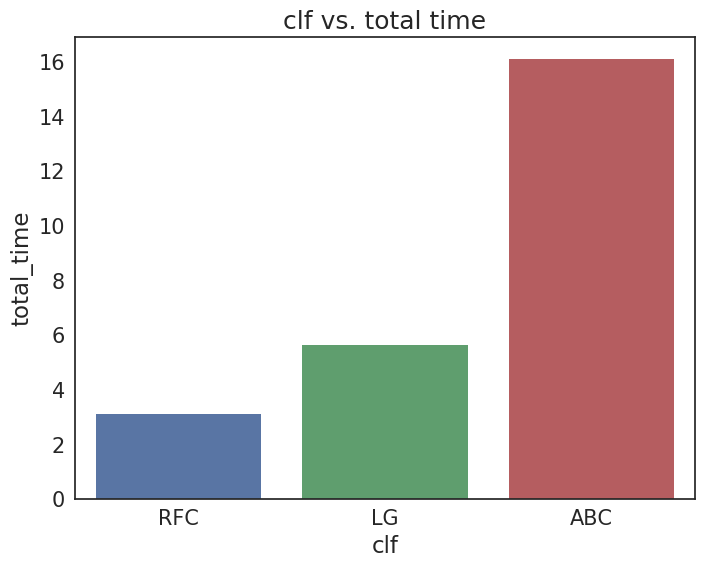

In [65]:
print (all_result)

plt.figure(figsize=(8,6))
plt.title('clf vs. total time')
sns.barplot(x='clf', y='total_time',data=all_result);

### Random Forest is the less time consuming model with highest accuracy
#### so we will train the whole dataset by this model

In [66]:
acc = []
f1 = []
total_time = 0
rfcalldict = {}
clfrfc = RandomForestClassifier(random_state=18)
param_grid = {'clf__max_depth':[2,6,12]}

pipe, grid, y_preds, f1score, accura,cost = make_pipeline(selector, clfrfc, param_grid, x, y)
total_time += cost
acc.append(accura)
f1.append(f1score)
print(accura,f1score)
print(cost)
    
    
rfcalldict.update({"accuracy":np.mean(acc),
               "f1_score":np.mean(f1),
               "total_time": total_time})

print(total_time)

/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/opt/conda/lib/python3.6/site-packages/sklearn/featu

0.81734706046 0.713510817383
1.1309540271759033
1.1309540271759033


/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [5] are constant.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [67]:
rfcalldict

{'accuracy': 0.81734706046030925,
 'f1_score': 0.71351081738262989,
 'total_time': 1.1309540271759033}

After training again, the accuracy of random forest is around 78%, the F1 value is 65%, and the model runs with very high speed, so I think that's a good choice.